In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Question 1: Propensity score matching

In [2]:
file_name = "lalonde.csv"
lalonde_data = pd.read_csv(file_name)
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Dataset description

- **treat:** 1 if the subject participated in the job training program, 0 otherwise
- **age:** the subject's age
- **educ:** years of education
- **race:** categorical variable with three possible values: Black, Hispanic, or White
- **married:** 1 if the subject was married at the time of the training program, 0 otherwise
- **nodegree:** 1 if the subject has earned no school degree, 0 otherwise
- **re74:** real earnings in 1974 (pre-treatment)
- **re75:** real earnings in 1975 (pre-treatment)
- **re78:** real earnings in 1978 (outcome)

In [3]:
lalonde_data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


## Subject who participated in the job training program

{'boxes': [<matplotlib.lines.Line2D at 0x114a51278>],
 'caps': [<matplotlib.lines.Line2D at 0x114a5ac50>,
 'fliers': [<matplotlib.lines.Line2D at 0x114a63e80>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x114a63668>],
 'whiskers': [<matplotlib.lines.Line2D at 0x114a51be0>,
  <matplotlib.lines.Line2D at 0x114a51dd8>]}

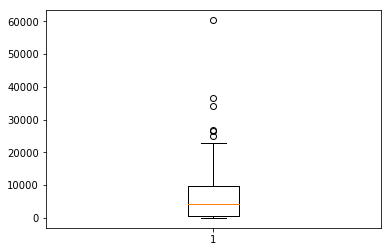

In [8]:
subject_JTP = lalonde_data[lalonde_data.treat==1].re78
plt.boxplot(subject_JTP)


## Subject who don't

{'boxes': [<matplotlib.lines.Line2D at 0x117f0fe48>],
 'caps': [<matplotlib.lines.Line2D at 0x117f23860>,
 'fliers': [<matplotlib.lines.Line2D at 0x117f2aa90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x117f2a278>],
 'whiskers': [<matplotlib.lines.Line2D at 0x117f0ffd0>,
  <matplotlib.lines.Line2D at 0x117f1bf60>]}

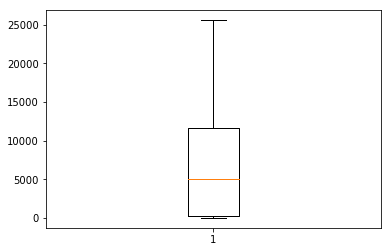

In [14]:
subject_nJTP = lalonde_data[lalonde_data.treat==0].re78
tmp = subject_nJTP.reset_index(drop=True)
#plt.boxplot(subject_nJTP)
plt.boxplot(tmp)

In [ ]:
Subject_JTP